In [1]:
using TrajectoryOptimization
using LinearAlgebra
using Plots

# Define dynamics
Dynamics should be defined using in-place operations

In [2]:
function cartpole_dynamics!(Ẋ, X, U)
    mc = 10.0;   # mass of the cart in kg (10)
    mp = 1.0;    # mass of the pole (point mass at the end) in kg
    l = 0.5;   # length of the pole in m
    g = 9.81;  # gravity m/s^2

    q = X[1:2];
    qd = X[3:4];

    if isfinite(q[2])
        s = sin(q[2])
        c = cos(q[2])
    else
        s = Inf
        c = Inf
    end

    H = [mc+mp mp*l*c; mp*l*c mp*l^2];
    C = [0 -mp*qd[2]*l*s; 0 0];
    G = [0; mp*g*l*s];
    B = [1; 0];

    qdd = -H\(C*qd + G - B*U');

    Ẋ[1:2] = qd
    Ẋ[3:4] = qdd
    return nothing
end

cartpole_dynamics! (generic function with 1 method)

# Create a model

In [3]:
n = 4
m = 1

model = Model(cartpole_dynamics!,n,m)

TrajectoryOptimization.AnalyticalModel(cartpole_dynamics!, 4, 1)

# Create an objective
A constrained objective can be created from an unconstrained objective

In [4]:
x0 = [0.0;0.0;0.0;0.0]
xf = [0.0;pi;0.0;0.0]

Q = 0.01*Diagonal(I,n)
Qf = 1000.0*Diagonal(I,n)
R = 0.01*Diagonal(I,m)

dt = 0.01
tf = 5.

obj_uncon = LQRObjective(Q, R, Qf, tf, x0, xf)

u_min = -30.
u_max = 30.

x_min = [-Inf;-Inf;-Inf;-Inf]
x_max = [Inf; Inf; Inf; Inf]
obj_con = ConstrainedObjective(obj_uncon,u_min=u_min, u_max=u_max, x_min=x_min, x_max=x_max);

# Create a solver
change default options as necessary

In [5]:
opts = SolverOptions()
opts.verbose = true

solver_uncon = Solver(model,obj_uncon,dt=dt,opts=opts)
solver_con = Solver(model,obj_con,dt=dt,opts=opts);

# Provide initial trajectory
either: U; X,U; none

In [6]:
U0 = ones(solver_uncon.model.m,solver_uncon.N-1);

# Solve problem

In [7]:
results_uncon, stats_uncon = solve(solver_uncon,U0)

┌ Info: Solving Unconstrained Problem...
└ @ TrajectoryOptimization C:\Users\taylor howell\.julia\dev\TrajectoryOptimization\src\ilqr_methods.jl:267
┌ Info: Outer loop 1 (begin)
└ @ TrajectoryOptimization C:\Users\taylor howell\.julia\dev\TrajectoryOptimization\src\solve.jl:173
    iter cost          expected    actual      z         α         c_max     dJ        ρ         grad      j         zero_count info                                              
____------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    1     3219.6158628  2498.69504              1.002034  0.25                2503.777  0e+00     103.5633 1         0          
    2     2953.8077918  2402.52472              0.110637  0.5                 265.8081  0e+00     29.8501  1         0          
    3     2843.7192767  146.598611              0.750952  0.03125             110.0885  0e+00     16.7434

    47    9.3434848418  0.11179262              1.450973  1                   0.162208  0e+00     0.175725 1         0          
    48    9.2995037433  0.06643061              0.662061  0.25                0.043981  0e+00     0.142773 1         0          
    49    9.2264901998  0.06737959              1.083615  1                   0.073014  0e+00     0.148036 1         0          
    50    9.2003029238  0.10829762              0.241808  0.25                0.026187  0e+00     0.195569 1         0          
    iter cost          expected    actual      z         α         c_max     dJ        ρ         grad      j         zero_count info                                              
____------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    51    9.1735088105  0.07438761              0.360196  0.5                 0.026794  0e+00     0.19624  1         0        

(UnconstrainedVectorResults(Array{Float64,1}[[0.0, 0.0, 0.0, 0.0], [0.000110899, -0.000221762, 0.0221795, -0.0443444], [0.000438097, -0.000875616, 0.0432591, -0.0864029], [0.000970387, -0.00193787, 0.0631972, -0.126009], [0.00169616, -0.00338322, 0.0819544, -0.163008], [0.00260342, -0.00518484, 0.0994943, -0.197252], [0.00367982, -0.00731453, 0.115783, -0.228609], [0.00491271, -0.00974278, 0.13079, -0.256953], [0.00628912, -0.0124389, 0.144488, -0.282175], [0.00779585, -0.0153712, 0.156851, -0.304175]  …  [-0.00131215, 3.13972, 0.0195819, 0.0398223], [-0.00112616, 3.1401, 0.0176164, 0.035562], [-0.00096005, 3.14043, 0.0156063, 0.0312824], [-0.000814265, 3.14072, 0.0135513, 0.0269742], [-0.000689256, 3.14097, 0.0114509, 0.0226281], [-0.00058548, 3.14118, 0.00930457, 0.0182346], [-0.000503399, 3.14134, 0.00711195, 0.0137843], [-0.000443478, 3.14145, 0.00487244, 0.00926718], [-0.000406189, 3.14152, 0.00258551, 0.00467338], [-0.000392009, 3.14155, 0.000250549, -7.33832e-6]], Array{Float64,

In [8]:
@assert norm(results_uncon.X[end] - xf) < 1e-3

In [9]:
results_con, stats_con = solve(solver_con,U0)

┌ Info: Solving Constrained Problem...
└ @ TrajectoryOptimization C:\Users\taylor howell\.julia\dev\TrajectoryOptimization\src\ilqr_methods.jl:267
┌ Info: Outer loop 1 (begin)
└ @ TrajectoryOptimization C:\Users\taylor howell\.julia\dev\TrajectoryOptimization\src\solve.jl:173
    iter cost          expected    actual      z         α         c_max     dJ        ρ         grad      j         zero_count info                                              
____------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    1     3562.5792283  2501.19888              0.866199  0.25      24.51345  2166.537  0e+00     103.5963 1         0          
    2     2760.5170676  831.15558               0.964996  0.125     21.47773  802.0622  0e+00     31.30525 1         0          
    3     2614.4122926  643.008255              0.227221  0.125     18.77503  146.1048  0e+00     21.31245 

    48    46.907473638  6.77136971              0.448512  0.125     2.019863  3.037043  0e+00     0.460193 1         0          
    49    43.724319245  6.06774066              0.524603  0.125     1.933377  3.183154  0e+00     0.401887 1         0          
    50    43.287331557  1.39843143              0.312484  0.03125   1.873024  0.436988  0e+00     0.36265  1         0          
    iter cost          expected    actual      z         α         c_max     dJ        ρ         grad      j         zero_count info                                              
____------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    51    41.513492172  9.69708745              0.182925  0.25      2.269643  1.773839  0e+00     0.354354 1         0          
    52    36.53491082   8.99512602              0.553475  0.25      1.736513  4.978581  0e+00     0.291559 1         0        

    iter cost          expected    actual      z         α         c_max     dJ        ρ         grad      j         zero_count info                                              
____------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    95    8.5813325747  0.01634898              1.063922  0.25      0.028778  0.017394  0e+00     0.064925 2         0          
    96    8.5796014172  0.00171908              1.007027  0.03125   0.027755  0.001731  0e+00     0.06335  2         0          
    97    8.5789621752  0.00084176              0.75941   0.015625  0.02726   0.000639  0e+00     0.063054 2         0          
outeriter iter iterations  info                                    
-------------------------------------------------------------------
2         97   3           
┌ Info: Outer loop 3 (begin)
└ @ TrajectoryOptimization C:\Users\taylor howell\.julia\dev\T

    iter cost          expected    actual      z         α         c_max     dJ        ρ         grad      j         zero_count info                                              
____------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    116   4760.5406623  0.1464871               1         1.53e-05  0.00858   0.146487  0e+00     6.610492 9         0          
    117   4760.5057628  0.07324159              0.476498  7.63e-06  0.00858   0.034899  0e+00     6.610384 9         0          
    118   4760.4674899  1.1717886               0.032662  0.000122  0.008579  0.038273  0e+00     6.606101 9         0          
    119   4759.2957107  1.17177923              1         0.000122  0.008578  1.171779  0e+00     6.605211 9         0          
    120   4759.1991963  0.14644447              0.659051  1.53e-05  0.008578  0.096514  0e+00     6.604347 9         0        

    iter cost          expected    actual      z         α         c_max     dJ        ρ         grad      j         zero_count info                                              
____------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    164  -5.6241169401  1.35938856              1.001515  0.5       0.000477  1.361448  0e+00     0.10543  10        0          
    165  -5.62590705    0.00179008              1.000015  0.001953  0.000477  0.00179   0e+00     0.073322 10        0          
    166  -5.6267990914  0.00089203              1.000007  0.000977  0.000477  0.000892  0e+00     0.073243 10        0          
outeriter iter iterations  info                                    
-------------------------------------------------------------------
10        166  3           
┌ Info: Outer loop 11 (begin)
└ @ TrajectoryOptimization C:\Users\taylor howell\.julia\dev\

(ConstrainedVectorResults(Array{Float64,1}[[0.0, 0.0, 0.0, 0.0], [7.3991e-5, -0.000147958, 0.014798, -0.0295862], [0.000299922, -0.000599457, 0.0303876, -0.0606973], [0.000685461, -0.00136894, 0.0467189, -0.0931722], [0.00123777, -0.00246922, 0.0637404, -0.126844], [0.00196347, -0.0039114, 0.0813987, -0.16154], [0.00286868, -0.00570484, 0.0996392, -0.197083], [0.00395892, -0.0078571, 0.118406, -0.233291], [0.00523917, -0.0103739, 0.137641, -0.269977], [0.00671383, -0.013259, 0.157286, -0.306952]  …  [-0.0100511, 3.12125, 0.203104, 0.41861], [-0.00810473, 3.12525, 0.186173, 0.38116], [-0.00633393, 3.12886, 0.167992, 0.341957], [-0.00475147, 3.13208, 0.148505, 0.30081], [-0.00337071, 3.13487, 0.12765, 0.257515], [-0.00220565, 3.13721, 0.105365, 0.211864], [-0.00127091, 3.13909, 0.081586, 0.163638], [-0.000581769, 3.14047, 0.0562446, 0.112609], [-0.000150528, 3.14133, 0.0300051, 0.0600032], [-4.81734e-7, 3.14163, 4.6021e-6, -9.16115e-6]], Array{Float64,1}[[14.7984], [15.593], [16.3407], [

In [10]:
@assert norm(results_con.X[end] - xf) < 1e-3
@assert stats_con["c_max"][end] < solver_con.opts.constraint_tolerance

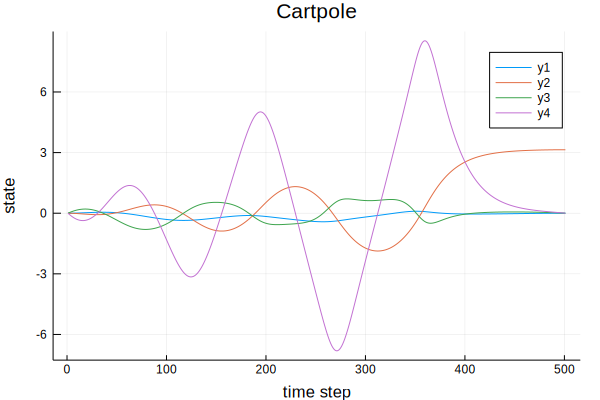

In [11]:
plot(results_uncon.X,title="Cartpole",xlabel="time step",ylabel="state")

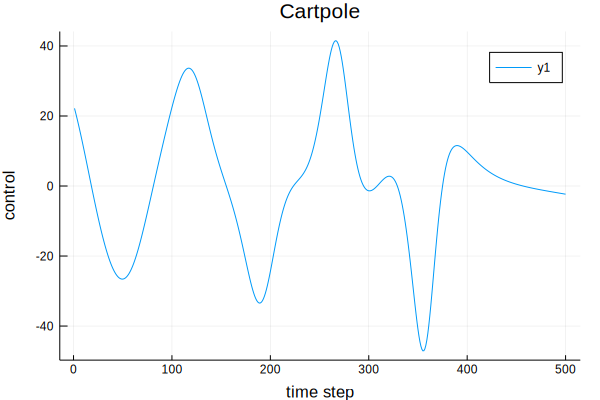

In [12]:
plot(results_uncon.U,title="Cartpole",xlabel="time step",ylabel="control")

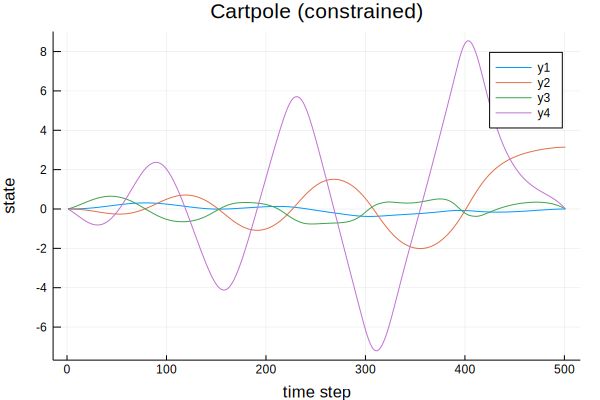

In [13]:
plot(results_con.X,title="Cartpole (constrained)",xlabel="time step",ylabel="state")

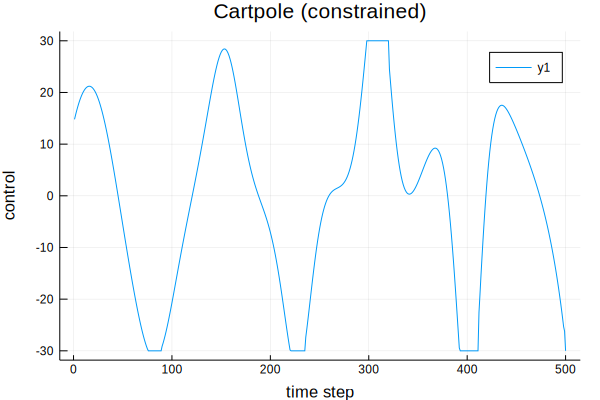

In [14]:
plot(results_con.U,title="Cartpole (constrained)",xlabel="time step",ylabel="control")